In [2]:
#import data_ingest
import numpy as np
import random
import scipy.stats as stat
import data_ingest
import csv
import glob
import os.path
from os import path
from datetime import datetime

In [3]:
# The basic CSV instrument. We'll abstract this later when we need it
class FileInstrument:
    def __init__(self, filename, load=True):
        self.datetime_format = '%d-%b-%Y'
        self.column_names = ['day', 'month', 'year', 'open', 'high', 'low', 'close', 'volume', 'forward_returns']
        self.column_set = set(self.column_names)
        
        self.data = None
        
        if load:
            self.load_file(filename)
        
    def load_file(self, filename):
        with open(filename) as f:
            item = []
            reader = csv.reader(f)
            for row in reader:
                _row = self.format_row(*row)
                item.append(_row)
                
        item = np.array(item)
        returns = np.expand_dims(100*(np.diff(item[:,-2], append=item[:,-2][-1]) / item[:,-2]), axis=1)
        
        items_with_returns = np.hstack((item, returns))

        self.data = items_with_returns
        
    def format_row(self, *args):
        date = datetime.strptime(args[0], self.datetime_format)
        o = float(args[1])
        h = float(args[2])
        l = float(args[3])
        c = float(args[4])
        v = int(args[5])

        return [date.day, date.month, date.year, o, h, l, c, v]
    
    def attach_feature(self, feature, name):
        self.column_set.add(name) # this will fail if the feature already exists
        self.column_names.append(name)
        
        f = np.expand_dims(feature, axis=1)
        self.data = np.hstack((self.data, f))
    
    def __getitem__(self, key):
        if type(key) == str:
            idx = self.column_names.index(key)
            return self.data[:,idx]
        
        return self.data.__getitem__(key)

    def __repr__(self):
        return self.data.__repr__()

In [4]:
#Load asset and create a random signal boolean mask.

asset = FileInstrument('C:/Users/ck6542/Documents/AlphaEngine/Seasonality generator/prices/prices/NYSE/LUV.csv')

mask = np.array([False if i % random.randint(10,20) else True for i in range(asset['forward_returns'].shape[0])])

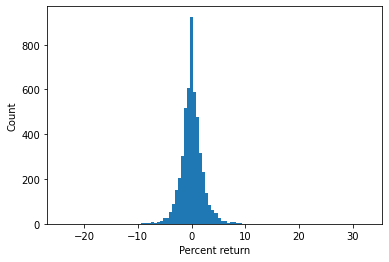

Kurtosis 18.14624715557299
Skew 0.48786409924109886


In [5]:
# Plot forward returns of asset.

import matplotlib.pyplot as plt
from scipy import stats

plt.hist(asset['forward_returns'],bins = 100)
plt.xlabel('Percent return')
plt.ylabel('Count')
plt.show()

print("Kurtosis", stats.kurtosis(asset['forward_returns']))
print("Skew", stats.skew(asset['forward_returns']))


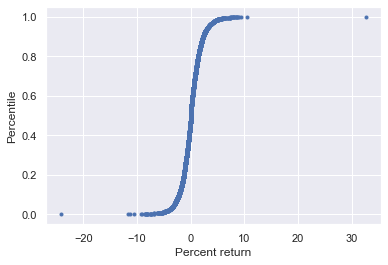

In [6]:
#Plot ECDF of forward % returns

import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = (len(data))

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDF for return data: x_return, y_return
x_return, y_return = ecdf(asset['forward_returns'])

# Generate plot
plt.plot(x_return,y_return, marker = '.', linestyle='none')

# Label the axes
plt.xlabel('Percent return')
plt.ylabel('Percentile')

# Display the plot
plt.show()

In [7]:
#Index the boolean mask, and attach to asset dataset.

signalindexes = np.where(mask == True)[0]
asset.attach_feature(mask, 'random')

In [8]:
#Calculate marked to market returns for each signal occurence.

signals_m2m_returns = []

for i in range(len(signalindexes)):
    signals_m2m_returns.append(np.cumsum(asset['forward_returns'][i:i+100]))


Mean return of signal by forward lookahead period 8.411501280436214


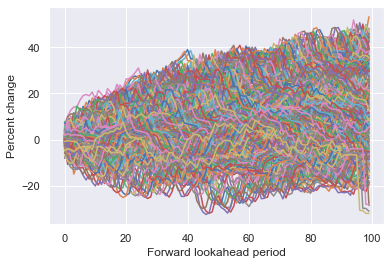

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

for i in signals_m2m_returns:
    plt.plot(i)
    plt.xlabel('Forward lookahead period')
    plt.ylabel('Percent change')

print("Mean return of signal by forward lookahead period", np.mean(signals_m2m_returns))

In [10]:
# Calculate rolling runup and drawdown. Maximum favorable excursion and maximum adverse excursion at each timestep.
# Max runup is "intra-trade runup", which indicates the maximum profit potential if perfect exit.abs
# Likewise, max drawdown  is "intra-trade drawdown", which indicated the maximum drawdown/loss potential, if an unlucky exit.

m2m_rolling_maxdd = []
m2m_rolling_maxrunup = []

for i in signals_m2m_returns:
    m2m_rolling_maxrunup.append(np.maximum.accumulate(i))
    m2m_rolling_maxdd.append(np.minimum.accumulate(i))


In [11]:
#Store max runup and max drawdown for each occurence of the signal.
#Get index of timestep where max runup and drawdown occured
import numpy as np

maxdrawdowns = []
maxrunups = []
maxrunup_timestep = []
maxdrawdown_timestep = []

assert len(m2m_rolling_maxdd) == len(m2m_rolling_maxrunup)

for i in range(len(m2m_rolling_maxrunup)):

    maxdrawdowns.append(np.min(m2m_rolling_maxdd[i]))
    maxrunups.append(np.max(m2m_rolling_maxrunup[i]))
    
    maxdrawdown_timestep.append(np.argmin((m2m_rolling_maxdd[i])))
    maxrunup_timestep.append(np.argmax((m2m_rolling_maxrunup[i])))



Mean profit potential for signal (%) 24.94175852256036


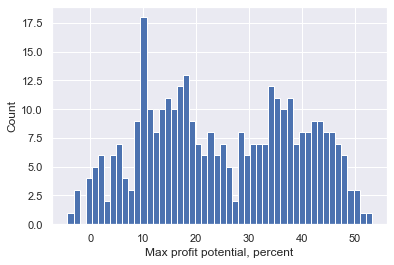

In [12]:
#Plot the distribution of runups / max profit potential.

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.hist(maxrunups, bins = int(50))
plt.xlabel('Max profit potential, percent')
plt.ylabel('Count')

print('Mean profit potential for signal (%)', np.mean(maxrunups))


Mean timestep at max profit 66.07163323782235


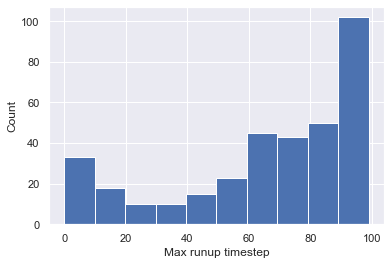

In [13]:
#Plot the distribution of timesteps where max runup occured

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.hist(maxrunup_timestep)
plt.xlabel('Max runup timestep')
plt.ylabel('Count')

print('Mean timestep at max profit', np.mean(maxrunup_timestep))

Mean timestep at max drawdown 29.432664756446993


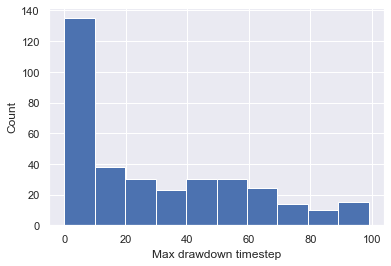

In [14]:
#Plot the distribution of timesteps where max drawdown occured

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.hist(maxdrawdown_timestep)
plt.xlabel('Max drawdown timestep')
plt.ylabel('Count')

print('Mean timestep at max drawdown', np.mean(maxdrawdown_timestep))

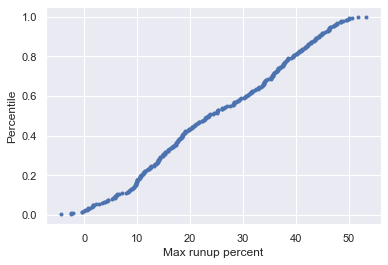

In [15]:
# Compute ECDF for maxrunups data: x_runup, y_runup

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

x_runup, y_runup = ecdf(maxrunups)

# Generate plot
plt.plot(x_runup,y_runup, marker = '.', linestyle='none')

# Label the axes
plt.xlabel('Max runup percent')
plt.ylabel('Percentile')

# Display the plot
plt.show()

Mean loss potential for signal (%) -8.760874532274167


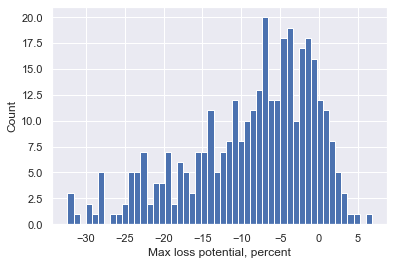

In [16]:
#Plot the distribution of max drawdowns / max drawdown/loss potential.

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

plt.clf()

plt.hist(maxdrawdowns, bins = int(50))

plt.xlabel('Max loss potential, percent')
plt.ylabel('Count')

print('Mean loss potential for signal (%)', np.mean(maxdrawdowns))


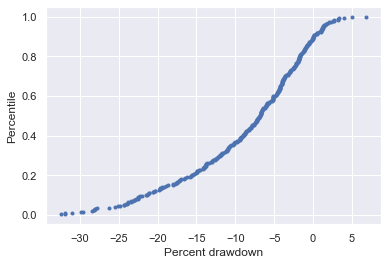

In [17]:
# Compute ECDF for drawdown data: x_dd, y_dd

x_dd, y_dd= ecdf(maxdrawdowns)

# Generate plot
plt.plot(x_dd,y_dd, marker = '.', linestyle='none')

# Label the axes
plt.xlabel('Percent drawdown')
plt.ylabel('Percentile')

# Display the plot
plt.show()

In [18]:
m2m_all_signals_maxrunup = np.max(maxrunups)
m2m_all_signals_maxdd = np.min(maxdrawdowns) 
m2m_all_signals_maxdd_maxprofit_ratio = m2m_all_signals_maxrunup / m2m_all_signals_maxdd

m2m_all_signals_maxprofit_skew = stat.skew(maxrunups)
m2m_all_signals_maxprofit_kurtosis = stat.kurtosis(maxrunups)
m2m_all_signals_maxdd_skew = stat.skew(maxdrawdowns)
m2m_all_signals_maxdd_kurtosis = stat.kurtosis(maxdrawdowns)

print('Marked to market - Highest profit potential', str(m2m_all_signals_maxrunup) + ' %')
print('Marked to market - Highest drawdown potential', str(m2m_all_signals_maxdd)  + ' %')
print('Marked to market - Ratio highest profit potential to highest drawdown potential', m2m_all_signals_maxdd_maxprofit_ratio)
print('Marked to market - Skew of profit potentials', m2m_all_signals_maxprofit_skew)
print('Marked to market - Kurtosis of profit potentials', m2m_all_signals_maxprofit_kurtosis)
print('Marked to market - Skew of drawdown potentials', m2m_all_signals_maxdd_skew)
print('Marked to market - Kurtosis of drawdown potentials', m2m_all_signals_maxdd_kurtosis)



Marked to market - Highest profit potential 53.205520783893654 %
Marked to market - Highest drawdown potential -32.407985475871016 %
Marked to market - Ratio highest profit potential to highest drawdown potential -1.6417410709933575
Marked to market - Skew of profit potentials 0.023111808524679204
Marked to market - Kurtosis of profit potentials -1.1520814857958186
Marked to market - Skew of drawdown potentials -0.7928036411590046
Marked to market - Kurtosis of drawdown potentials -0.055743007421811264


In [37]:
import talib

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)







mean_mfe = running_mean(asset['high'], 20)

mean_mae = running_mean(asset['low'], 20)

print(mean_mfe/mean_mae)



atr = talib.ATR(asset['high'], asset['low'], asset['close'], timeperiod=20)

e = mean_mfe / mean_mae

plt.plot(e)



 



# e_ratios = np.array((np.array(m2m_rolling_maxrunup))) / np.mean((np.array(m2m_rolling_maxdd)))

#mean_eratios = np.mean(e_ratios,axis=0, dtype=float)


"""


lowest_lows = []
highest_highs = []

highest_highs = np.maximum.accumulate(asset['high'])
lowest_lows = np.minimum.accumulate(asset['low'])

e_ratio = (lowest_lows / atr) / (highest_highs / atr)

print(len(e_ratio))

#Calculate marked to market returns for each signal occurence.

signals_m2m_returns = []

for i in range(len(signalindexes)):
    signal_e_ratios.append(e_ratio[i:i+10])

plt.plot(signal_e_ratios[100])
"""

ValueError: operands could not be broadcast together with shapes (2351,) (2313,) 